In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

from vocoder import Channel_Vocoder

In [2]:
# Basic params
sr = 44100
hop_length = 512
n_fft = 2048

In [3]:
# Audio Selection
import ipywidgets as widgets

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w = widgets.Dropdown(
    options=[('dog_sound', 'dog_sound'), 
             ('suzanne', 'suzanne')],
    value='dog_sound',
    description='Select audio:',
)

w.observe(
    lambda c: plot_content(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)
ipd.display(w)

Dropdown(description='Select audio:', options=(('dog_sound', 'dog_sound'), ('suzanne', 'suzanne')), value='dog…

In [4]:
# Load Audio
modulator_x, _ = librosa.load("./audio/{}.wav".format(w.value), sr=sr) 
print(modulator_x.shape)
ipd.Audio(modulator_x, rate=sr)

(98817,)


In [8]:
# Vocoding 
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr, freq_scale='linear', filter_type='biquad')
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440)
ipd.Audio(output, rate=sr)

## + Debug bandpass filtering

In [6]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr, freq_scale='linear')

# Change bp_origin as you want
bp_origin = modulator_x
bp_result = channel_vocoder.bp_filtering(bp_origin, channel_idx=2)

ipd.Audio(bp_result, rate=sr)

/home/jnwn/anaconda3/envs/gct535/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


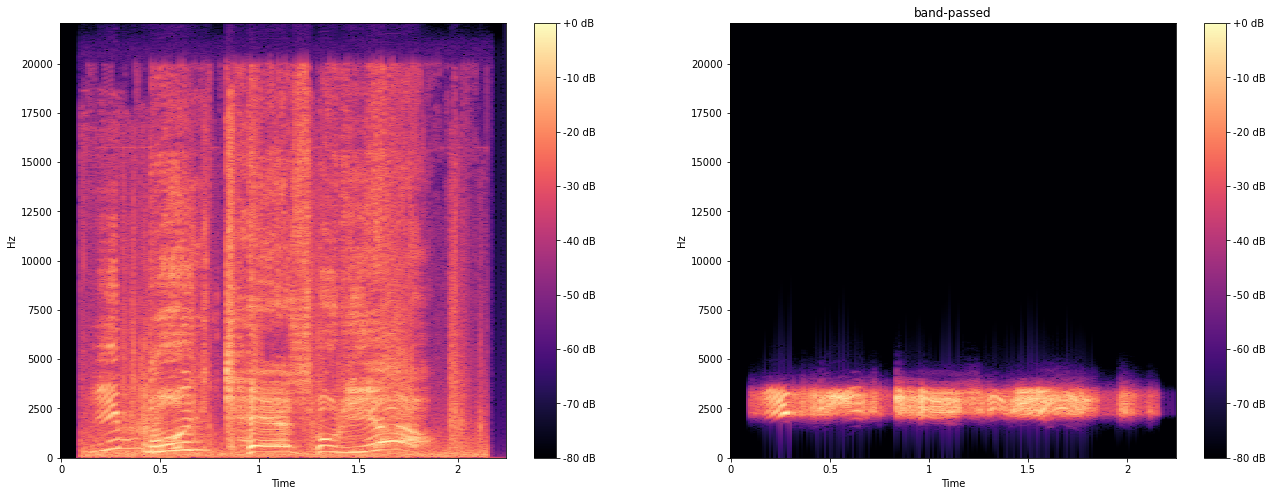

In [7]:
fig, axes = plt.subplots(1,2, figsize=(22,8))

hop_length = 512
n_fft = 2048

bp_origin = librosa.stft(bp_origin, window='hann', n_fft=n_fft, hop_length=hop_length)
log_bp_origin = librosa.power_to_db(bp_origin, ref=np.max)
img = librosa.display.specshow(log_bp_origin, x_axis="time", y_axis="linear", sr=sr, ax=axes[0])
plt.title('original')
plt.colorbar(img, ax=axes[0], format="%+2.f dB")

bp_result = librosa.stft(bp_result, window='hann', n_fft=n_fft, hop_length=hop_length)
log_bp_result = librosa.power_to_db(bp_result, ref=np.max)
img = librosa.display.specshow(log_bp_result, x_axis="time", y_axis="linear", sr=sr, ax=axes[1])
plt.title('band-passed')
plt.colorbar(img, ax=axes[1], format="%+2.f dB")